# Load parcellated connectomes v0.2.3

In [8]:
import os
import nibabel as nib
import numpy as np
from brainspace.utils.parcellation import map_to_labels
from brainspace.mesh.mesh_io import read_surface
from brainspace.plotting import plot_hemispheres

In [9]:
def load_annot(atlas, surf='fsaverage5'):
    '''
    Script that loads the labels of an specific parcellation and generates a midwall mask
    '''
    
    # Load LEFT annotation file in fsaverage5
    annot_lh_fs5= nib.freesurfer.read_annot(f'{micapipe}/parcellations/lh.{atlas}_mics.annot')

    # Unique number of labels of a given atlas
    Ndim = max(np.unique(annot_lh_fs5[0]))
    
    if surf == 'fsaverage5':

        # Load RIGHT annotation file in fsaverage5
        annot_rh_fs5= nib.freesurfer.read_annot(f'{micapipe}/parcellations/rh.{atlas}_mics.annot')[0]+Ndim

        # replace with 0 the medial wall of the right labels
        annot_rh_fs5 = np.where(annot_rh_fs5==Ndim, 0, annot_rh_fs5) 

        # fsaverage5 labels
        labels = np.concatenate((annot_lh_fs5[0], annot_rh_fs5), axis=0)
    
    else:
        # Read label for fsLR-32k
        labels = np.loadtxt(open(f'{micapipe}/parcellations/{atlas}_conte69.csv'), dtype=int)

    # mask of the medial wall
    mask = labels != 0
    
    # Midwall labels of aparc-a2009s are lh=42 and rh=117
    if atlas == 'aparc-a2009s' and surf == 'fsaverage5':
        mask[(labels == 117) | (labels == 42)] = 0
    
    return(labels, mask, Ndim)


def load_mpc(File, Ndim):
    """Loads and process a MPC"""

    # load the matrix
    mtx_mpc = nib.load(File).darrays[0].data

    # Mirror the matrix
    MPC = np.triu(mtx_mpc,1)+mtx_mpc.T

    # Remove the medial wall
    MPC = np.delete(np.delete(MPC, 0, axis=0), 0, axis=1)
    MPC = np.delete(np.delete(MPC, Ndim, axis=0), Ndim, axis=1)
    
    return(MPC)

def load_fc(File, Ndim, parc=''):
    """Loads and process a functional connectome"""

    # load the matrix
    mtx_fs = nib.load(File).darrays[0].data

    # slice the matrix remove subcortical nodes and cerebellum
    FC = mtx_fs[49:, 49:]
    
    # Fisher transform
    FCz = np.arctanh(FC)

    # replace inf with 0
    FCz[~np.isfinite(FCz)] = 0

    # Mirror the matrix
    FCz = np.triu(FCz,1)+FCz.T
    return(FCz)

def load_gd(File, Ndim):
    """Loads and process a GD"""

    # load the matrix
    mtx_gd = nib.load(File).darrays[0].data

    # Remove the Mediall Wall
    mtx_gd = np.delete(np.delete(mtx_gd, 0, axis=0), 0, axis=1)
    GD = np.delete(np.delete(mtx_gd, Ndim, axis=0), Ndim, axis=1)

    return(GD)

def load_sc(File, Ndim, log_transform=True):
    """Loads and process a structura connectome"""

    # load the matrix
    mtx_sc = nib.load(File).darrays[0].data

    # Mirror the matrix
    if log_transform != True:
        mtx_sc = np.triu(mtx_sc,1)+mtx_sc.T
    else:
        mtx_sc = np.log(np.triu(mtx_sc,1)+mtx_sc.T)
    mtx_sc[np.isneginf(mtx_sc)] = 0

    # slice the matrix remove subcortical nodes and cerebellum
    SC = mtx_sc[49:, 49:]
    SC = np.delete(np.delete(SC, Ndim, axis=0), Ndim, axis=1)

    # replace 0 values with almost 0
    SC[SC==0] = np.finfo(float).eps
    
    return(SC)

In [10]:
# Set the working directory to the 'out' directory
out='/data_/mica3/BIDS_PNI/derivatives'
os.chdir(out)

# This variable will be different for each subject
sub='PNC019'
ses='a1'
subjectID=f'sub-{sub}_ses-{ses}'           
subjectDir=f'micapipe_v0.2.0/sub-{sub}/ses-{ses}' 

# Path to MICAPIPE from global enviroment
micapipe=os.popen("echo $MICAPIPE").read()[:-1]

In [11]:
# Load fsLR-32k inflated (64984 vertices both hemispheres)
f32k_lh = read_surface(f'{micapipe}/surfaces/fsLR-32k.L.inflated.surf.gii', itype='gii')
f32k_rh = read_surface(f'{micapipe}/surfaces/fsLR-32k.R.inflated.surf.gii', itype='gii')

# Load fsaverage5 inflated (20484 vertices both hemispheres)
fs5_lh = read_surface(f'{micapipe}/surfaces/fsaverage5/surf/lh.inflated', itype='fs')
fs5_rh = read_surface(f'{micapipe}/surfaces/fsaverage5/surf/rh.inflated', itype='fs')


## Load a Functional Connectome from different parcellations

In [14]:
# Define a list of parcelations to load
parc = ['aparc', 'economo', 'glasser-360',
         'schaefer-100','schaefer-200','schaefer-300','schaefer-400',
         'schaefer-500','schaefer-600','schaefer-800',
         'vosdewael-100','vosdewael-200',
         'vosdewael-300','vosdewael-400']

# NaN color
nan_col = (0.8, 0.8, 0.8, 1)

# Empty list of surface plots
roi_fs5 = [None] * len(parc)
roi_32k = [None] * len(parc)

for i, atlas in enumerate(parc):
    
    # Load fsaverage5 labels
    labels_fs5, mask_fs5, Ndim = load_annot(atlas, surf='fsaverage5')
    # Load fsLR-32k labels
    labels_32k, mask_32k, _ = load_annot(atlas, surf='fsLR-32k')

    # Define the aqcquisition
    acq_func='desc-me_task-rest_bold'
    
    # Set the path to the GIFTI file to load
    file = f'{subjectDir}/func/{acq_func}/surf/{subjectID}_atlas-{atlas}_desc-FC.shape.gii'

    # Load the FC 
    mtx = load_fc(file, Ndim)
    
    # Column sum
    mtx_s = np.sum(mtx, axis=0)

    # Map labels to surface fsaverage5
    roi_fs5[i] = map_to_labels(mtx_s, labels_fs5,  fill=np.nan, mask=mask_fs5)
    # Map labels to surface fsLR-32k
    roi_32k[i] = map_to_labels(mtx_s, labels_32k,  fill=np.nan, mask=mask_32k)


/host/yeatman/local_raid/temporaryLocalProcessing/ipykernel_1566586/2182631120.py:47: RuntimeWarning: divide by zero encountered in arctanh
  FCz = np.arctanh(FC)


## Anatomy based parcellations: `fsaverage5`

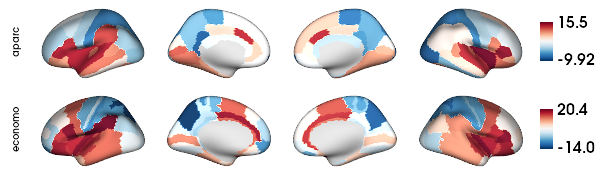

In [15]:
# Plot parcellations
plot_hemispheres(fs5_lh, fs5_rh, array_name=roi_fs5[0:2], size=(600, 175), cmap='RdBu_r',
                 embed_nb=True, label_text={'left':parc[0:2]}, color_bar='right',
                 zoom=1.5, nan_color=nan_col)

## Anatomy based parcellations: `fsLR-32k`

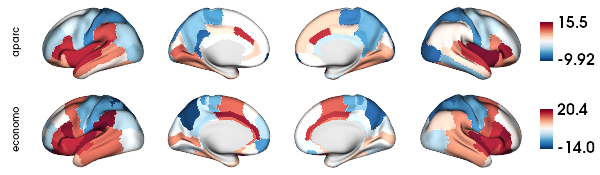

In [16]:
# Plot parcellations
plot_hemispheres(f32k_lh, f32k_rh, array_name=roi_32k[0:2], size=(600, 175), cmap='RdBu_r',
                 embed_nb=True, label_text={'left':parc[0:2]}, color_bar='right',
                 zoom=1.5, nan_color=nan_col)

## Multimodal based parcellations: `fsaverage5`

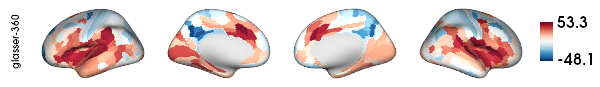

In [17]:
# Plot parcellations
plot_hemispheres(fs5_lh, fs5_rh, array_name=roi_fs5[2], size=(600, 87), cmap='RdBu_r',
                 embed_nb=True, label_text={'left':[parc[2]]}, color_bar='right',
                 zoom=1.5, nan_color=nan_col)

## Multimodal based parcellations: `fsLR-32k`

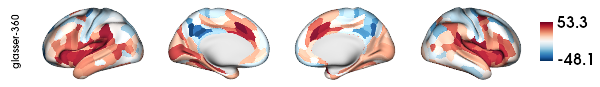

In [18]:
# Plot parcellations
plot_hemispheres(f32k_lh, f32k_rh, array_name=roi_32k[2], size=(600, 87), cmap='RdBu_r',
                 embed_nb=True, label_text={'left':[parc[2]]}, color_bar='right',
                 zoom=1.5, nan_color=nan_col)

## Functional based parcellations: `fsaverage5`

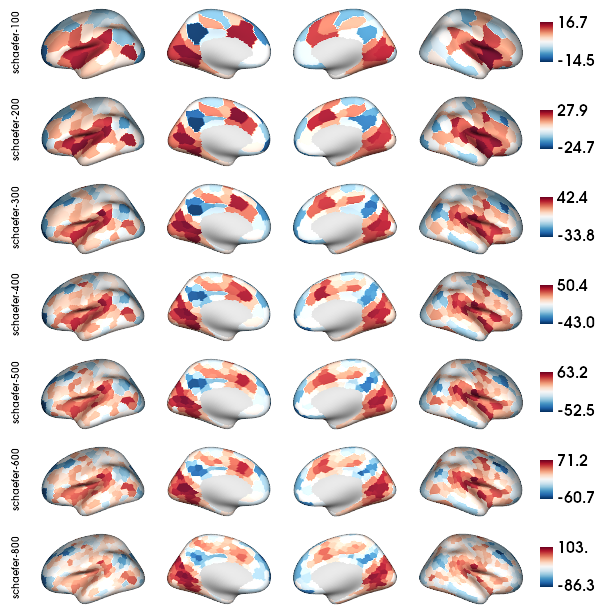

In [20]:
# Plot parcellations
plot_hemispheres(fs5_lh, fs5_rh, array_name=roi_fs5[3:10], size=(600, 613), cmap='RdBu_r',
                 embed_nb=True, label_text={'left':parc[3:10]}, color_bar='right',
                 zoom=1.5, nan_color=nan_col)

## Functional based parcellations: `fsLR-32k`

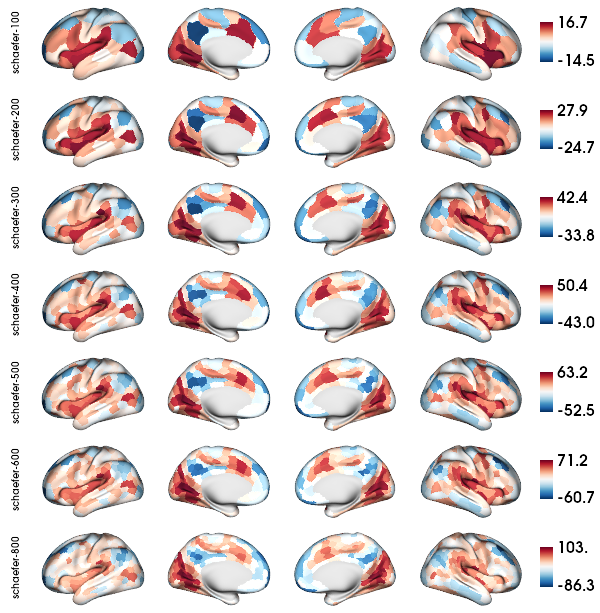

In [21]:
# Plot parcellations
plot_hemispheres(f32k_lh, f32k_rh, array_name=roi_32k[3:10], size=(600, 613), cmap='RdBu_r',
                 embed_nb=True, label_text={'left':parc[3:10]}, color_bar='right',
                 zoom=1.5, nan_color=nan_col)

## Pseudo-random parcellation based on *Desikan Killiany*: `fsaverage5`


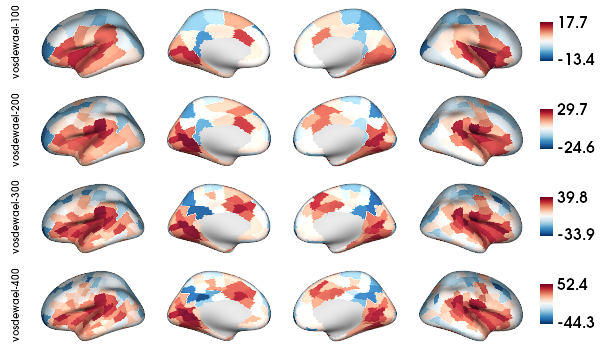

In [23]:
# Plot parcellations
plot_hemispheres(fs5_lh, fs5_rh, array_name=roi_fs5[10:14], size=(600, 350), cmap='RdBu_r',
                 embed_nb=True, label_text={'left':parc[10:14]}, color_bar='right',
                 zoom=1.5, nan_color=nan_col)

## Pseudo-random parcellation based on *Desikan Killiany*: `fsLR-32k`


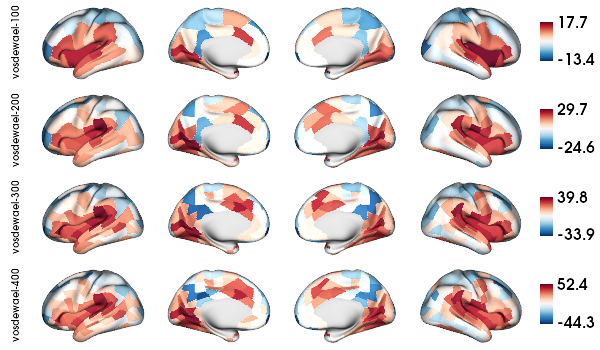

In [24]:
# Plot parcellations
plot_hemispheres(f32k_lh, f32k_rh, array_name=roi_32k[10:14], size=(600, 350), cmap='RdBu_r',
                 embed_nb=True, label_text={'left':parc[10:14]}, color_bar='right',
                 zoom=1.5, nan_color=nan_col)